# Time-dependent Wave Functions

The aim here is to employ use of a high-fidelity solver in order to approximate the time-dependent Schrodinger equation. We will again start by focusing on the Harmonic Oscillator, then move on to studying non-linear cases, specifically the Gross-Pitaevski equation. Once we're successfully able to establish a high-accuracy numerical solution in both cases, our plan is explore how dynamical methods, like DMD, may help us reduce compuation time.

Lets start by importing the libraries we'll be using for the high fidelity solver.

In [142]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.integrate import quad
import time
import math
from pydmd import DMD

Next, lets define some functions that will allow us to preform our time propogation.

Firstly, we'll construct the hamiltonian of the harmonic oscillator. We know the hamiltonian of the harmonic oscillator is equal to the following:

$$ \hat{H} =  \frac{\hat{p}^2}{2m} + \frac{1}{2}m\omega^2\hat{x}^2$$

Where p-hat is the momentum operator, x-hat is the position operator, m is the mass of our particle, and omega represents the angular velocity.

We know the following about the momentum operator:

$$ \hat{p} = i\hbar\frac{\partial}{\partial x} $$

This allows us to rewrite our hamiltonian with respect only to position space, like so:

$$ \hat{H} =  \frac{-\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + \frac{1}{2}m\omega^2\hat{x}^2$$

We can represent this hamiltonian as a square matrix, where each the number of elements each row/column is equal to the inverse of our spacial steps (dx). Using finite difference methods, we can approximate the second derivative in this expression. Let us set this up using numpy. Note, q represents omega in the function below.

In [143]:
def construct_hamiltonian(N, x, dx, h_bar, mass, q):
    potential =  (mass * x**2 * q**2)/2
    potential = np.diag(potential)

    hamiltonian = np.zeros((N, N))#,dtype=np.complex128)
    
    #finite_diff = -2 * np.eye(N)
    #finite_diff += np.eye(N, k=1)
    #finite_diff += np.eye(N, k=-1)

    finite_diff = -(5/2) * np.eye(N)
    finite_diff += (4/3) * np.eye(N, k=1)
    finite_diff += (4/3) * np.eye(N, k=-1)
    finite_diff += -(1/12) * np.eye(N, k=2)
    finite_diff += -(1/12) * np.eye(N, k=-2)
    
    kinetic = -h_bar**2 / (2 * mass) * (finite_diff/dx**2)
    
    hamiltonian = kinetic + potential

    return hamiltonian

It would also be useful to define an function that acts as our time evolution operator, generally given by:

$$ e^{\frac{i\hat{H}t}{\hbar}} $$

Unfortunately, this operator is not of much use to us in this form. In order to be mathematically compatible with the hamiltonian matrix we defined earlier, we have to preform a taylor series expansion of this exponential.

FINISH EXPANSION


In [144]:
def taylor_series_expansion(matrix, terms, t):
    n = matrix.shape[0]
    identity = np.eye(n, dtype=np.complex128)
    result = identity.copy()
    matrix_power = matrix.copy()

    # Expand time evolution operator e^(-itH)
    for i in range(1, terms + 1):
        term = (matrix_power**i) * (t**i) * (-1j**i) / math.factorial(i)
        result += term

    return result

Now that both of those functions are established, lets start visualizing some solutions.

In order to solve for our actual wavefunction, lets consider the following relation:

$$ \hat{H} \ket{\psi} = E \ket{\psi}$$


REWORK THIS

Where E is a states eigenvalue and psi is the wavefunction (also known as the eigenfunction). To solve this eigensystem, its acceptable to use either numpy or scipys built-in solver (use eig for numpy, eigh for scipy). Its worth noting here that the results will vary slightly depending on which library is used. The numpy solution seems to have an extra factor of -1 present in the eigenfunction, which can be easily corrected with an additional factor. I'm not certain the reason for this, and would like to spend time analyzing the inner workings of both of these functions. However, for now we'll simply use the scipy version to avoid unnecessary factors. Its likely I'll explore at a later time this outside of this notebook.

So with the above in mind, we can start by setting some constants and a domain. We can then plug these into our hamiltonian function and solve for the eigensystem. In this notebook, we'll be primarily focused on the ground state, but note that there techncially exists an infinite number of excited states. To check if our hamiltonian was generated correctly, we'll graph eigenvectors of the ground state to visualize the wavefunction. Take care to seperate the real and imaginary parts when graphing. This will become important once we start propagating through time!

[[ 290.0125     -148.00666667    9.25041667 ...    0.
     0.            0.        ]
 [-148.00666667  289.67918168 -148.00666667 ...    0.
     0.            0.        ]
 [   9.25041667 -148.00666667  289.35036766 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  289.35036766
  -148.00666667    9.25041667]
 [   0.            0.            0.         ... -148.00666667
   289.67918168 -148.00666667]
 [   0.            0.            0.         ...    9.25041667
  -148.00666667  290.0125    ]]


Text(0, 0.5, 'Wavefunction')

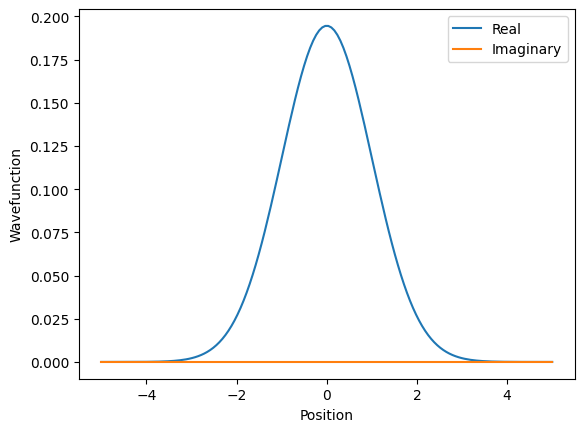

In [145]:
h_bar = 1#.05457e-35
mass = 1
q = 1
N = 150

x = np.linspace(-5, 5, N)
dx = x[1] - x[0]

H = construct_hamiltonian(N, x, dx, h_bar, mass, q)
print(H)

# Differences between sp and np?
#eigenvalues, eigenvectors = np.linalg.eigh(H)
eigenvalues, eigenvectors = sp.linalg.eigh(H)
initial_state = eigenvectors.copy()

plt.plot(x, np.real(initial_state[:,0]))
plt.plot(x, np.imag(initial_state[:,0]))
plt.legend(["Real","Imaginary"])
plt.xlabel("Position")
plt.ylabel("Wavefunction")

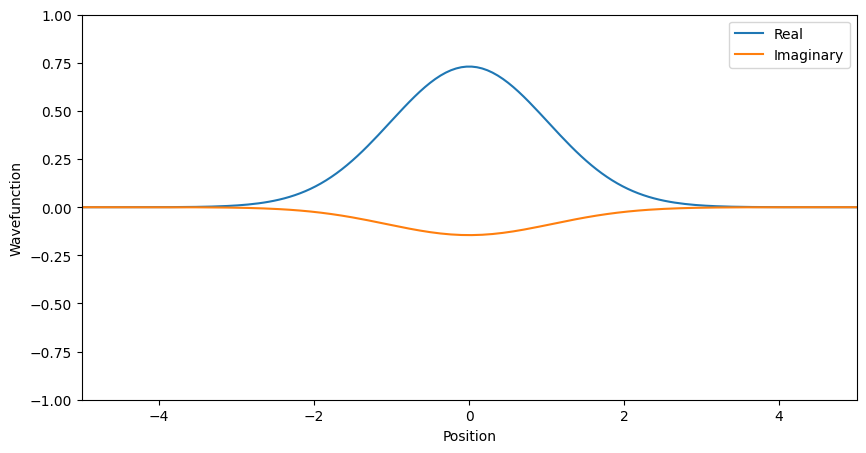

<Figure size 1000x500 with 0 Axes>

In [150]:
t = 0
t_max = 1
t_steps = 5000
t_values = np.linspace(t, t_max, t_steps)
dt = t_values[1] - t_values[0]
count = 0
terms = 3

fig, ax = plt.subplots(figsize=(10, 5))

initial_state1 = initial_state[:,0]

total_energies = []
def potential_energy(x):
    return 0.5 * mass * q**2 * x**2


while t <= t_max:
    total_energy = 0

    if t == 0:
        final_state = initial_state1.copy()
        final_state_norm = final_state/np.sqrt(np.dot(final_state,np.conj(final_state))*dx)

        def energy(x):
            psi_x = final_state_norm
            return np.real(np.conj(psi_x) @ H @ psi_x)
        total_energy, _ = quad(energy, -5, 5)
        total_energies.append(total_energy)

    
    else:

        teo = taylor_series_expansion(H, terms, dt)
        new_state = np.dot(teo, final_state_norm)
        final_state_norm = final_state_norm + new_state
        final_state_norm = final_state_norm/np.sqrt(np.dot(final_state_norm,np.conj(final_state_norm))*dx)

        total_energy, _ = quad(energy, -5, 5)
        total_energies.append(total_energy)

    plt.plot(x, (np.real(final_state_norm[:])))
    plt.plot(x, (np.imag(final_state_norm[:])))
    
    plt.xlim([-5,5])
    plt.ylim([-1,1])

    plt.xlabel("Position")
    plt.ylabel("Wavefunction")
    plt.legend(["Real","Imaginary"])#,"Probability Density"])
    clear_output(wait=True)  
    display(fig) 
    fig.clear()
    

    t += dt
    count += 1

$$\langle E \rangle = \bra{\psi} \hat{H} \ket{\psi}$$


Text(0.5, 1.0, 'Ground State Energy')

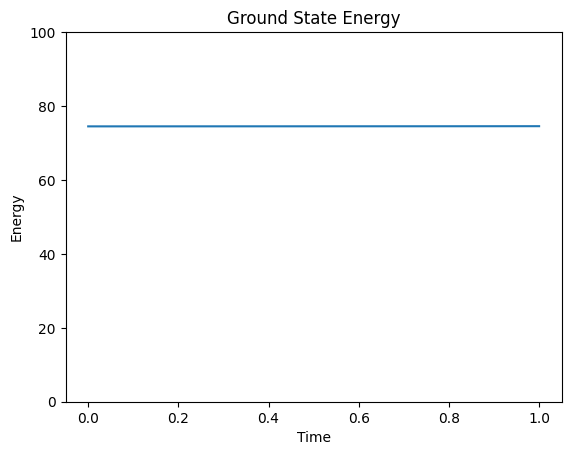

In [154]:
plt.plot(t_values, total_energies)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.ylim(0, 100)
plt.title("Ground State Energy")

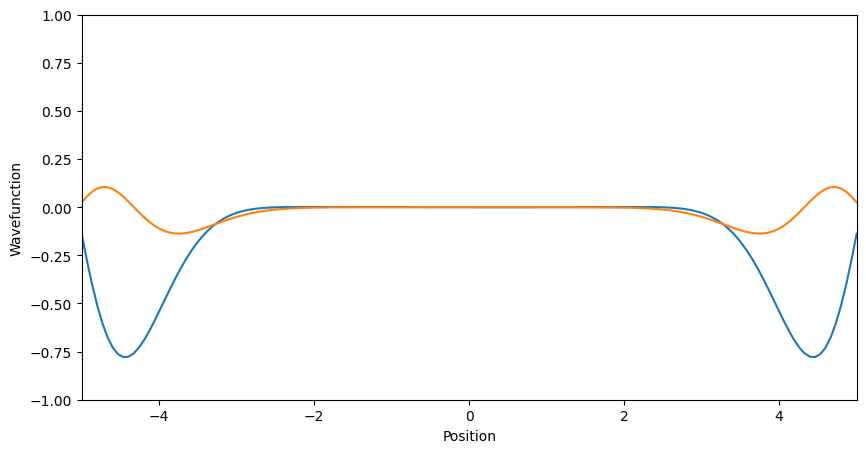

<Figure size 1000x500 with 0 Axes>

In [22]:
h_bar = 1#.05457e-35
mass = 1
q = 1
N = 150

x = np.linspace(-5, 5, N)
dx = x[1] - x[0]

initial_state = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

t = 0
t_max = 100
t_steps = 10000
t_values = np.linspace(t, t_max, t_steps)
dt = t_values[1] - t_values[0]
count = 0
terms = 7

fig, ax = plt.subplots(figsize=(10, 5))

while t <= t_max:

    if t == 0:
        final_state = initial_state.copy()
        final_state_norm = final_state/np.sqrt(np.dot(final_state,np.conj(final_state))*dx)
    
    else:

        #teo = taylor_series_expansion(H, terms, dt)
        #new_state = np.dot(teo, final_state)
        #print(new_state)
        #final_state = final_state.astype(np.complex128)
        #final_state = new_state.copy()
        #final_state = final_state/(np.linalg.norm(final_state)*dx)

        teo = taylor_series_expansion(H, terms, dt)
        new_state = np.dot(teo, final_state_norm)
        final_state_norm = final_state_norm + new_state
        final_state_norm = final_state_norm/np.sqrt(np.dot(final_state_norm,np.conj(final_state_norm))*dx)

    pd = np.abs(final_state)**2
    plt.plot(x, (np.imag(final_state_norm[:])))
    plt.plot(x, (np.real(final_state_norm[:])))
    #plt.plot(x, pd[:])
    plt.xlim([-5,5])
    plt.ylim([-1,1])

    plt.xlabel("Position")
    plt.ylabel("Wavefunction")
    clear_output(wait=True)  
    display(fig) 
    fig.clear()

    t += dt
    count += 1

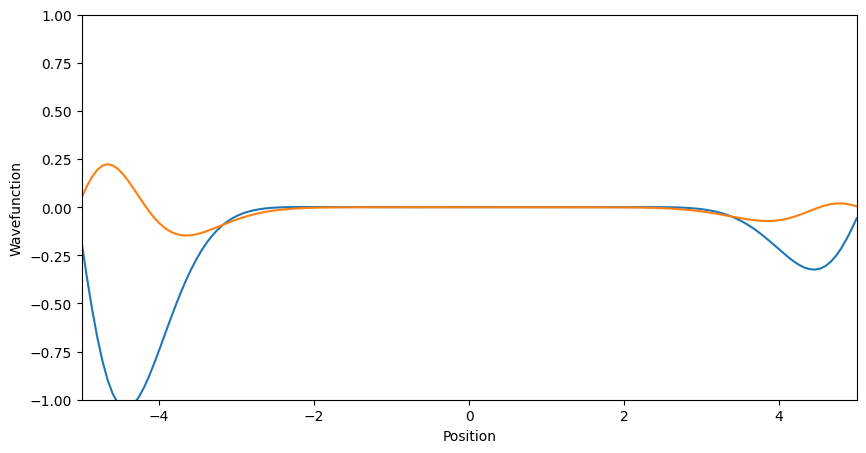

<Figure size 1000x500 with 0 Axes>

In [23]:
h_bar = 1#.05457e-35
mass = 1
q = 1
N = 150

x = np.linspace(-5, 5, N)
dx = x[1] - x[0]

initial_state = np.exp(-(x+0.2)**2 / 2.0) / np.sqrt(np.pi+2)

t = 0
t_max = 100
t_steps = 10000
t_values = np.linspace(t, t_max, t_steps)
dt = t_values[1] - t_values[0]
count = 0
terms = 7

fig, ax = plt.subplots(figsize=(10, 5))

while t <= t_max:

    if t == 0:
        final_state = initial_state.copy()
        final_state_norm = final_state/np.sqrt(np.dot(final_state,np.conj(final_state))*dx)
    
    else:

        #teo = taylor_series_expansion(H, terms, dt)
        #new_state = np.dot(teo, final_state)
        #print(new_state)
        #final_state = final_state.astype(np.complex128)
        #final_state = new_state.copy()
        #final_state = final_state/(np.linalg.norm(final_state)*dx)

        teo = taylor_series_expansion(H, terms, dt)
        new_state = np.dot(teo, final_state_norm)
        final_state_norm = final_state_norm + new_state
        final_state_norm = final_state_norm/np.sqrt(np.dot(final_state_norm,np.conj(final_state_norm))*dx)

    pd = np.abs(final_state)**2
    plt.plot(x, (np.imag(final_state_norm[:])))
    plt.plot(x, (np.real(final_state_norm[:])))
    #plt.plot(x, pd[:])
    plt.xlim([-5,5])
    plt.ylim([-1,1])

    plt.xlabel("Position")
    plt.ylabel("Wavefunction")
    clear_output(wait=True)  
    display(fig) 
    fig.clear()

    t += dt
    count += 1

In [8]:
def run_simulation_save(Nx, Nt, terms):
    
    h_bar = 1
    mass = 1
    q = 1

    x = np.linspace(-5, 5, Nx)
    dx = x[1] - x[0]
    t = 0
    t_max = 5
    t_values = np.linspace(t, t_max, Nt)
    dt = t_values[1] - t_values[0]
    count = 0

    time_start = time.time()

    H = construct_hamiltonian(Nx, x, dx, h_bar, mass, q)

    eigenvalues, eigenvectors = sp.linalg.eigh(H)
    initial_state = eigenvectors.copy()
    initial_state1 = initial_state[:,0]
    all_states = np.zeros((150, *np.shape(H)), dtype=complex)
    #initial_state2 = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

    while t <= t_max:

        if t == 0:
            final_state = initial_state1.copy()
        #final_state_norm = final_state/(np.linalg.norm(final_state)*dx)
            final_state_norm = final_state/np.sqrt(np.dot(final_state,np.conj(final_state))*dx)
            if count < 150:
                all_states[count, :, :] = final_state_norm[:]
        #norm = final_state / np.linalg.norm(prob_density)*dx
    
        else:

            teo = taylor_series_expansion(H, terms, dt)
            new_state = np.dot(teo, final_state_norm)
            final_state_norm = final_state_norm + new_state
        #final_state_norm = final_state.astype(np.complex128)
        #final_state_norm = new_state.copy()
        #final_state_norm = final_state/(np.linalg.norm(final_state)*dx)
            final_state_norm = final_state_norm/np.sqrt(np.dot(final_state_norm,np.conj(final_state_norm))*dx)
            if count < 150:
                all_states[count, :, :] = final_state_norm[:]


        t += dt
        count += 1

    time_finish = time.time()
    time_diff = time_finish - time_start
    
    return initial_state, final_state_norm, all_states, time_diff

In [9]:
i_state2, f_state2, a_states2, timer2 = run_simulation_save(150,1000,7)
#print(a_states2)

In [52]:
dmd = DMD(svd_rank = 7)
dmd.fit(a_states2.T)

c:\Users\kozy8\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 2.1485962192163873e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


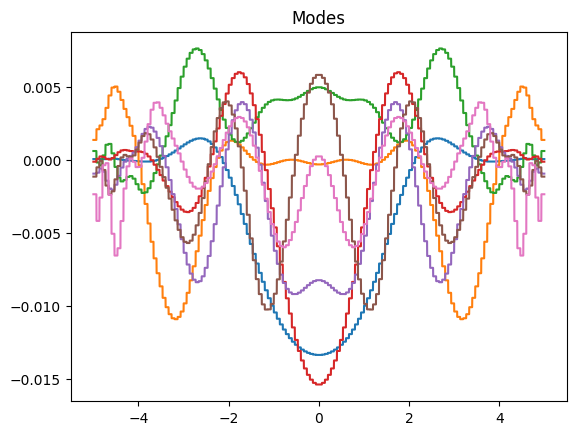

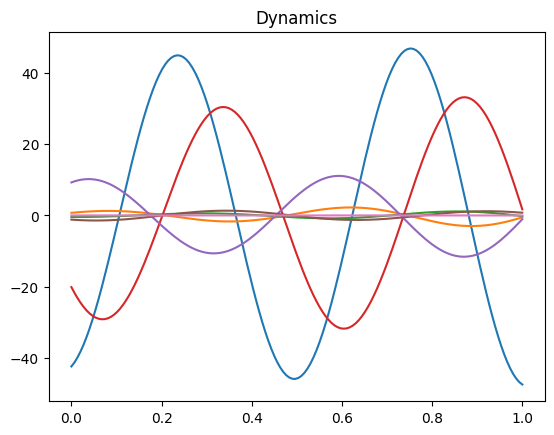

In [53]:
for mode in dmd.modes.T:
    x_values = np.linspace(-5, 5, len(mode.real)) 
    plt.plot(x_values, mode.real)
    plt.title('Modes')
    
plt.show()

for dynamic in dmd.dynamics:
    t = np.linspace(0, 1,len(dynamic.real))
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
    #plt.xlim((0-,10))
plt.show()

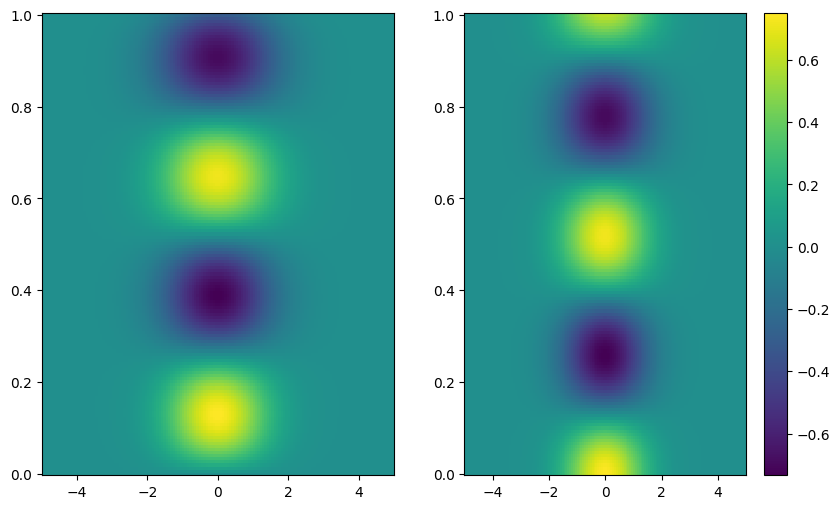

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
#plt.pcolor(x_values, t, (mode.reshape(-1, 1).dot(dynamic.reshape(1, -1))).real.T)
plt.pcolor(x_values, t, dmd.reconstructed_data.imag.T)
plt.subplot(1,2,2)
plt.pcolor(x_values, t, dmd.reconstructed_data.real.T)
plt.colorbar()

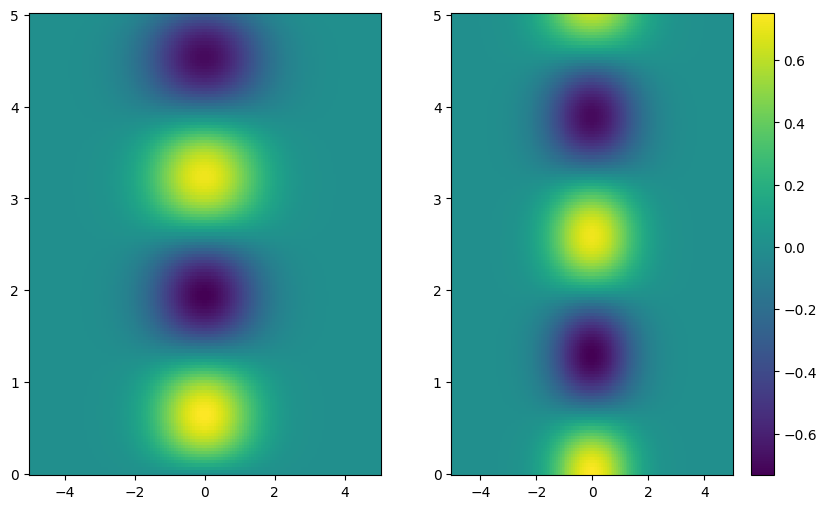

In [31]:
t = 0
t_max = 5
t_values = np.linspace(t, t_max, 150)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
#plt.pcolor(x_values, t, (mode.reshape(-1, 1).dot(dynamic.reshape(1, -1))).real.T)
plt.pcolor(x, t_values, a_states2[:,0].imag)
plt.subplot(1,2,2)
plt.pcolor(x, t_values, a_states2[:,0].real)
plt.colorbar()

In [140]:
num_steps = 100
t = 0
t_max = 5
t_values = np.linspace(t, t_max, 10000)
dt = t_values[1] - t_values[0]
count = 0

fig, ax = plt.subplots(figsize=(10, 5))

propagated_state = np.zeros((len(initial_state), 150**2), dtype=complex)

propagated_state_initial = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
propagated_state_initial = propagated_state_initial.astype(complex)

propagated_state_initial = propagated_state[:, 0]
plt.plot(x_values, propagated_state[0,:])
plt.xlabel('Position')
plt.ylabel('Time')
plt.title('Title')
plt.show()
clear_output(wait=True)  
display(fig) 
fig.clear()

#propagated_state = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
#propagated_state = propagated_state.astype(complex)

for i in range(1, 10000 + 1):
    time = i * dt
    for k in range(len(dmd.eigs)):
        mode_evolution = dmd.modes[:, k].T * np.exp(dmd.eigs[k] * time)
        propagated_state[0, :] += mode_evolution



    plt.plot(x_values, propagated_state[0,:])
    plt.xlabel('Position')
    plt.ylabel('Time')
    plt.title('Title')
    plt.show()
    clear_output(wait=True)  
    display(fig) 
    fig.clear()

<Figure size 1000x500 with 0 Axes>

KeyboardInterrupt: 

In [84]:
print(np.shape(dmd.eigs), np.shape(dmd.modes.T), np.shape(propagated_state),np.shape(mode_evolution))
print(dmd.eigs)

(7,) (7, 22500) (150, 22500) (22500,)
[0.99721251+0.08157111j 1.00398753+0.07909942j 1.00484582+0.07534523j
 0.99797807+0.07882178j 0.99813216+0.07601244j 0.99592322+0.07296795j
 0.99417458+0.06541817j]


In [110]:
plt.pcolormesh?

Signature:
plt.pcolormesh(
    *args,
    alpha=None,
    norm=None,
    cmap=None,
    vmin=None,
    vmax=None,
    shading=None,
    antialiased=False,
    data=None,
    **kwargs,
)
Docstring:
Create a pseudocolor plot with a non-regular rectangular grid.

Call signature::

    pcolormesh([X, Y,] C, **kwargs)

*X* and *Y* can be used to specify the corners of the quadrilaterals.

.. hint::

   `~.Axes.pcolormesh` is similar to `~.Axes.pcolor`. It is much faster
   and preferred in most cases. For a detailed discussion on the
   differences see :ref:`Differences between pcolor() and pcolormesh()
   <differences-pcolor-pcolormesh>`.

Parameters
----------
C : array-like
    The mesh data. Supported array shapes are:

    - (M, N) or M*N: a mesh with scalar data. The values are mapped to
      colors using normalization and a colormap. See parameters *norm*,
      *cmap*, *vmin*, *vmax*.
    - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    - (M, N, 4): an image with

Sources:

https://dr.ascsn.net/HO_Time/HO_Time_Dependent.html

https://en.wikipedia.org/wiki/Finite_difference_coefficient

https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator

https://www.databookuw.com/page-3/page-10/

https://pydmd.github.io/PyDMD/

